## VASP Band structure calculator

Anyone who's ever had to calculate a hybrid-functional band structure in VASP knows that it is an incrediably fiddly procedure, anyone who hasn't should be happy. The routine involves performing an initial calculation at GGA level, generating $k$-points and then pasting special points with zero weighting to a new KPOINTS file for the hybrid calculation.

The VASP version of the procedure is outlined [here](http://cms.mpi.univie.ac.at/wiki/index.php/Si_bandstructure). In this example we have more-or-less automated the procedure in ASE. 

The kpoints module of ASE contains special points for most common lattice types. FCC, BCC, Hexagonal, Orthorhombic, Tetragonal. NB I had to add in Monoclinic to my version. It also contains information on the high symmetry paths through the respective Brillouin zones. In this tutorial we will make use of these features.

## Setting up VASP to work with ASE

To do this you need to set two environment variables; the VASP executable command and the path to the VASP pseudopotentials.

The setup is described [on the ASE site.](https://wiki.fysik.dtu.dk/ase/ase/calculators/vasp.html) Although I have personally found more success by setting the executable variable using 

* export VASP_COMMAND="vasp"

In [19]:
%matplotlib inline
from ase.lattice import bulk
from ase.dft.kpoints import *
import numpy as np
import os
from ase.calculators.vasp import Vasp
from ase.lattice.spacegroup import crystal
import matplotlib.pyplot as plt
from ase.dft.bandgap import get_band_gap 

## Primitive cell maker
Below is a quick function to build a primitive cell Atoms object from a conventional cell Atoms object. Well, you wouldn't want to waste CPU time, would you?

In [28]:
def primitive_from_conventional_cell(atoms, spacegroup=1, setting=1):
    """Returns primitive cell given an Atoms object for a conventional
    cell and it's spacegroup."""
    from ase.lattice.spacegroup import Spacegroup
    from ase.utils.geometry  import cut
    sg = Spacegroup(spacegroup, setting)
    prim_cell = sg.scaled_primitive_cell  # Check if we need to transpose
    return cut(atoms, a=prim_cell[0], b=prim_cell[1], c=prim_cell[2])

In [29]:
# Set up the system (Si)
a = 5.459
si = crystal('Si', [(0,0,0)], spacegroup=227, cellpar=[a, a, a, 90, 90, 90])
si = primitive_from_conventional_cell(si,spacegroup=227, setting=1)

In [30]:
# Set up the sampling path
path = high_symm_path['fcc']
points = get_special_points('fcc')
point_coords = []
for point in path:
    point_coords.append(points[point])
kpts, x, X = get_bandpath(point_coords,si.cell,100)

**NOTE** the sampling paths can be overly exhaustive and you may want to define reduced paths yourself, as in the example folders in this directory.

## The First VASP calculation

This is a single point calculation. Performed at GGA level, it generates the $k$-point mesh for 4x4x4 sampling.

In [31]:
calc_single = Vasp(system = "Generic System Name",
               istart = 0,iniwav = 1,icharg = 0,gamma=True,reciprocal=True,
               prec="Accurate", lreal = False, algo = "Normal", encut = 300.00,
               nelm = 200, ediff = 1e-6, gga = "PS",kpts=(4,4,4),
               ediffg = 1e-3, nsw = 0, ibrion = 1, isif = 3, isym = 2,
               ismear = -5)

si.set_calculator(calc_single)
energy = si.get_potential_energy()

## Make hybrid KPOINTS file
Now for the fiddling around to convert the irreducable $k$-points from that calculation to the KPOINTS file for the band structure

In [32]:
ibzkpts = calc_single.get_ibz_k_points()
weights = calc_single.read_k_point_weights()
kpts = np.concatenate((ibzkpts,kpts))
dummy = np.zeros(shape=(len(kpts),4))
for i in range(len(ibzkpts)):
    dummy[i,3] = weights[i]
dummy[:,:-1] = kpts
kpts = dummy

## The band structure calculation

**NOTE** on this occasion we run the band structure at GGA level. This is in the interests of brevity of the calculation and can easily be changed to hybrid-DFT in the calculator definition.

In [33]:
calc_band = Vasp(system = "Band structure",
               encut = 500.00,
               gga = "PS",
               kpts=kpts,
               nsw = 0,
               ismear = 0,
               sigma = 0.01,
               reciprocal = True)
si.set_calculator(calc_band)
print "Band Calc"
bands = si.get_potential_energy()

Band Calc


## Analysing and plotting the output

In this case we will use matplotlib to plot our structures. We will also use som of the nice built-in features of ASE to get information such as the band gap, the direct band gap and the transitions involved in each.

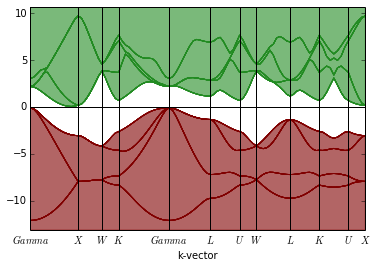

In [38]:
# Get the band energies across the Brillouin zone
e_kn = np.array([calc_band.get_eigenvalues(k) for k in range(len(kpts))])

# Get Fermi energy
ef = calc_band.get_fermi_level()
nbands = calc_band.get_number_of_bands()

# Plotting time
e_kn -= ef
emin = e_kn.min() - 1.0
emax = e_kn[:, nbands-1].max() + 1.0

# Plot the energy Vs k-point for each band
nelect = calc_band.get_number_of_electrons()
for n in range(nbands):

# Choose colour based on valence or conduction
    for n in range(nbands):
        if n < nelect/2:
            plt.plot(x, e_kn[len(ibzkpts):len(kpts), n],color='#800000')
        else:
            plt.plot(x, e_kn[len(ibzkpts):len(kpts), n],color='#228B22')

# Shade in valence and conduction bands
plt.fill_between(x,emin,e_kn[len(ibzkpts):len(kpts), nelect/2 - 1],color='#800000',alpha=0.6)
plt.fill_between(x,e_kn[len(ibzkpts):len(kpts), nelect/2],emax,color='#228B22',alpha=0.6)

# Set thick lines at each k-point
for p in X:
    plt.plot([p, p], [emin, emax], 'k-')

# Set the axis tick marks and labels
plt.plot([0, X[-1]], [0, 0], 'k-')
plt.xticks(X, ['$%s$' % n for n in path])
plt.axis(xmin=0, xmax=X[-1], ymin=emin, ymax=emax)
plt.xlabel('k-vector')


# Save the plot
plt.savefig('bands.pdf')
